In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pylab as plt

### Observations

- Feature 2: Showing an interesting trend
- Feature 5 and 6: boolean
- 

In [8]:
usecols=["Feature1","Feature2","Feature3", "Y"]
delimiter = ";"
df = pd.read_csv("./data.csv", header=0, sep=delimiter)

df.head(-1)

,Y,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,13500,23,46986,1.0,90,1,0,2000,3,1165
1,13750,23,72937,1.0,90,1,0,2000,3,1165
2,13950,24,41711,1.0,90,1,0,2000,3,1165
3,14950,26,48000,1.0,90,0,0,2000,3,1165
4,13750,30,38500,1.0,90,0,0,2000,3,1170
...,...,...,...,...,...,...,...,...,...,...
1430,8450,80,23000,NaN,86,0,0,1300,3,1015
1431,7500,69,20544,NaN,86,1,0,1300,3,1025
1432,10845,72,19000,NaN,86,0,0,1300,3,1015
1433,8500,71,17016,NaN,86,0,0,1300,3,1015


In [22]:
df.shape

(1436, 10)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Y          1436 non-null   int64  
 1   Feature 1  1436 non-null   int64  
 2   Feature 2  1436 non-null   int64  
 3   Feature 3  414 non-null    float64
 4   Feature 4  1436 non-null   int64  
 5   Feature 5  1436 non-null   int64  
 6   Feature 6  1436 non-null   int64  
 7   Feature 7  1436 non-null   int64  
 8   Feature 8  1436 non-null   int64  
 9   Feature 9  1436 non-null   int64  
dtypes: float64(1), int64(9)
memory usage: 112.3 KB


In [10]:
df.describe() 

,Y,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
count,1436.000000,1436.000000,1436.000000,414.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.00000
mean,10730.824513,55.947075,68533.259749,0.173913,101.502089,0.674791,0.055710,1566.827994,4.033426,1072.45961
std,3626.964585,18.599988,37506.448872,0.379493,14.981080,0.468616,0.229441,187.182436,0.952677,52.64112
min,4350.000000,1.000000,1.000000,0.000000,69.000000,0.000000,0.000000,1300.000000,2.000000,1000.00000
25%,8450.000000,44.000000,43000.000000,0.000000,90.000000,0.000000,0.000000,1400.000000,3.000000,1040.00000
50%,9900.000000,61.000000,63389.500000,0.000000,110.000000,1.000000,0.000000,1600.000000,4.000000,1070.00000
75%,11950.000000,70.000000,87020.750000,0.000000,110.000000,1.000000,0.000000,1600.000000,5.000000,1085.00000
max,32500.000000,80.000000,243000.000000,1.000000,192.000000,1.000000,1.000000,2000.000000,5.000000,1615.00000


<Axes: >

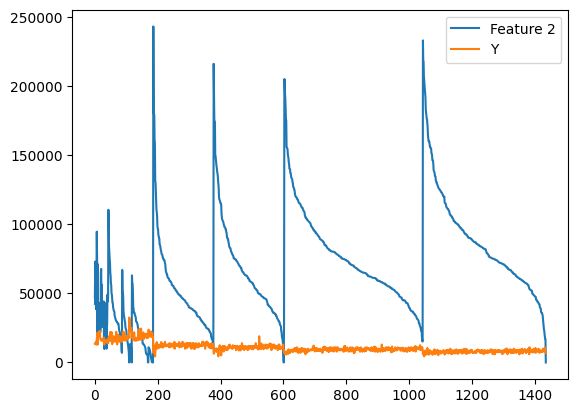

In [45]:
df[["Feature 2", "Y"]].plot()


In [42]:
print(df["Feature 5"].value_counts())
print(df["Feature 6"].value_counts())

Feature 5
1    969
0    467
Name: count, dtype: int64
Feature 6
0    1356
1      80
Name: count, dtype: int64


<Axes: ylabel='count'>

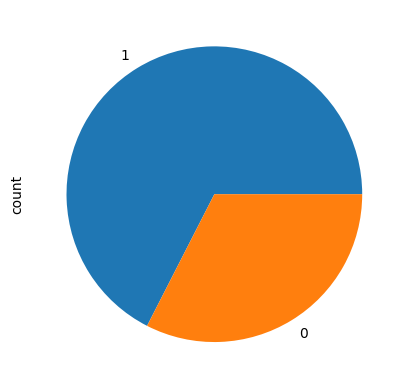

In [40]:
df["Feature 5"].value_counts().plot.pie()

In [21]:
df.isna().sum()

Y               0
Feature 1       0
Feature 2       0
Feature 3    1022
Feature 4       0
Feature 5       0
Feature 6       0
Feature 7       0
Feature 8       0
Feature 9       0
dtype: int64